# Training a model

Below is the example for a Gaussian Process classification example using GpyTorch :class:`.VariationalGaussianProcessClassifier`

This example shows how to use a GridInducingVariationalGP module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable

torch.manual_seed(7)
# The train data points are spaced every 1/25 between 0 and 1 inclusive
train_x = Variable(torch.linspace(0, 1, 26))
# Use the sign function (-1 if value <0, 1 if value>0) to assign
# periodic labels to the data
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import VariationalGaussianProcessClassifier

In [14]:
# Step 1: Define the GP model
# Create a model to classify, we use a GridInducingVariationalGP which exploits
# grid structure (the x data points are linspace)
# to get fast predictive distributions
class GPClassificationModel(gpytorch.models.GridInducingVariationalGP):
    def __init__(self):
        # For Pipeline to work, we should changed grid_bounds (to (-2,2), for example) 
        # in the original GPyTorch Example, and increase max_epoches as well !!!!!
        super(GPClassificationModel, self).__init__(grid_size=32, grid_bounds=[(0, 1)])
        # Near-zero constant mean
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # RBF kernel as universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Register RBF lengthscale as hyperparameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        # Calc predictive mean (zero)
        mean_x = self.mean_module(x)
        # Calc predictive covariance
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        # Make predictive distribution from predictive mean and covariance
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

In [15]:
# Step 2: Wrap the model into our GP Wrapper
GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 200
)

# Step 3: Find optimal model hyperparameters
GPWrapper.fit(X=train_x, y=train_y)

# Step 4: Prediction
# Test x are regularly spaced by 0.01 0,1 inclusive
test_x = Variable(torch.linspace(0, 1, 101))
observed_pred = GPWrapper.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1      665.2292  0.0260
      2      473.0207  0.0453
      3      338.7597  0.0426
      4      253.0622  0.0506
      5      188.2359  0.0460
      6      132.4029  0.0427
      7       87.9939  0.0467
      8       57.8081  0.0495
      9       40.1763  0.0472
     10       30.2989  0.0428
     11       24.1678  0.0410
     12       19.4501  0.0444
     13       17.4781  0.0427
     14       17.0752  0.0446
     15       17.0454  0.0401
     16       17.1284  0.0419
     17       16.0213  0.0419
     18       14.7203  0.0408
     19       14.3037  0.0758
     20       13.1166  0.0944
     21       11.9015  0.0612
     22       10.4692  0.0449
     23        9.3376  0.0505
     24        8.5778  0.0449
     25        7.2836  0.0425
     26        6.1544  0.0421
     27        5.0163  0.0456
     28        4.7313  0.0500
     29        4.1420  0.0440
     30        3.7540  0.0456
     31        3.1477  0.0415
     32   

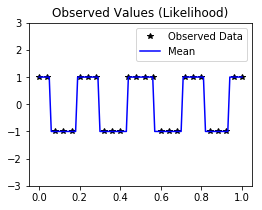

In [16]:
# (*) Step 5: Plotting
# Initialize fig and axes for plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))

# Plotting function
# A lot of this should be consolidated as helper between different notebooks
def ax_plot(ax, rand_var, title):
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
    ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

# Plot square wave predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Note: For Pipeline to work, we should changed grid_bounds in cell [4](to (-2,2), for example) 
# in the original GPyTorch Example, and increase max_epoches as well !!!!!
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GPWrapper),
])

pipe.fit(X=train_x.unsqueeze(-1), y=train_y)

  epoch    train_loss     dur
-------  ------------  ------
      1      526.7797  0.0316
      2      354.3727  0.0444
      3      232.0656  0.0384
      4      156.2462  0.0390
      5      101.7927  0.0378
      6       59.7346  0.0398
      7       32.4055  0.0460
      8       19.2975  0.0463
      9       15.6292  0.1423
     10       15.2891  0.0906
     11       14.9444  0.0446
     12       13.4122  0.0485
     13       11.3031  0.0450
     14        9.8106  0.0485
     15        8.5520  0.0465
     16        8.2542  0.0431
     17        7.2996  0.0442
     18        7.0582  0.0465
     19        6.4610  0.0464
     20        6.0982  0.0395
     21        5.9499  0.0495
     22        5.3710  0.0527
     23        5.4890  0.0494
     24        4.8685  0.0529
     25        5.4636  0.0506
     26        4.8729  0.0462
     27        4.5530  0.0506
     28        4.8972  0.0425
     29        4.7505  0.0450
     30        5.4522  0.0480
     31        4.7942  0.0444
     32   

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.VariationalGaussianProcessClassifier'>[initialized](
  module_=GPClassificationModel(
    (mean_module): ConstantMean()
    (covar_module): GridKernel(
      (base_kernel_module): RBFKernel()
    )
  ),
))])

# Grid search (Under construction)
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}

GPWrapper = VariationalGaussianProcessClassifier(
    module = GPClassificationModel,
    train_split = None,
    max_epochs = 200
)

gs = GridSearchCV(GPWrapper, params, refit=False, cv=3, scoring='accuracy',
                  return_train_score=False)  # Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1      966.8552  0.0271
      2      925.8406  0.0425
      3      887.6171  0.0413
      4      851.6039  0.0392
      5      818.0740  0.0354
      6      786.7318  0.0451
      7      757.1562  0.0373
      8      729.5147  0.0355
      9      703.5017  0.0418
     10      678.7001  0.0727
  epoch    train_loss     dur
-------  ------------  ------
      1      971.7765  0.1070
      2      929.5168  0.0930
      3      889.9679  0.1153
      4      853.0980  0.0867
      5      818.7068  0.0931
      6      786.6728  0.0885
      7      756.7657  0.0894
      8      728.2684  0.0486
      9      701.8292  0.0481
     10      677.0917  0.0478
  epoch    train_loss     dur
-------  ------------  ------
      1      937.8278  0.0454
      2      898.8004  0.0463
      3      862.3668  0.0459
      4      828.1891  0.0440
      5      796.4184  0.0418
      6      766.6042  0.0434
      7      738.6562  0.0424
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`